# KZ NOTE:

    Simply replacing dv with dv+noise doesn't seem to help.
    
    Trying concatenate dv and dv+noise (Double number of training): seems even worse lol

In [1]:
import time, sys, os
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchsummary import summary
import tqdm
from scipy.stats import norm
from scipy.interpolate import interp1d

from compression_nn.preprocess import prepare_data_for_training
from compression_nn.compression_nn import CompressionNN
from compression_nn.utils import plot_test_error_all_param_3param

import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
    use_cuda=True
else:
    print('CUDA Not Available')
    device = torch.device('cpu')
    use_cuda=False
cudnn.benchmark = True      #May train faster but cost more memory


CUDA Available


In [3]:
STATS = 'WL_23_WPH_short_CMBWL'

GAUSSIAN_AUG_STRENTH = 0.1
BATCH_SIZE           = 16 #
LEARNING_RATE        = 0.0005
NUM_EPOCH            = 300
WEIGHT_DECAY_RATE    = 0.01
SCHEDULER_FACTOR     = 0.3
SCHEDULER_PATIENCE   = 10


In [4]:
DD = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/compression/compression_data_combined.npy',allow_pickle=True).item()
stat = DD['stat']
mask = DD['mask']
target = DD['data']

# wph get rid of stuff that's degenerate with wl2 and wl3
# this defines "WPH_short"
mask_l = np.array(16*[ True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
        True,  True, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False])
mask_nbody_wph = np.hstack([np.array([False]*60),np.array([False]*120),mask_l])

# these keys are DVs that don't exist. 
# These indices are defined to select from their corresponding odict ('original dictionary') DVs that do exist
indict2 = dict()
indict2['WL_23_WPH_short'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_3_WPH_short'] = np.concatenate( ( list( range(160, 320) ), np.array( range(320, 1076))[mask_nbody_wph]) )
indict2['WL_23_WPH_short_CMBWL'] = np.concatenate( ( list( range(320) ), np.array( range(320, 1076))[mask_nbody_wph], list(range(1076, 1108) )) )
indict2['WPH'] = np.array( range(160, 916))[mask_nbody_wph]
indict2['CMBWL'] = range(160, 192)

odict = dict()
odict['WL_3_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short'] = 'WL_23_WPH'
odict['WL_23_WPH_short_CMBWL'] = 'WL_23_WPH_WCMBL'
odict['WPH'] = 'WL_2_WPH'
odict['CMBWL'] = 'WL_2_WCMBL'

for key in odict.keys():
    print(key)
    stat[key] = stat[odict[key]].copy()
    stat[key]['dv'] = stat[key]['dv'][:,indict2[key]]
        

swapind = np.array([0,1,2,3,4,13,14,15,9,10,11,12,5,6,7,8,16])   # om s8 w a e .    ob ns h ...   dm dz

for key in stat.keys():
    stat[key]['params'] = stat[key]['params'][:,swapind]

# defining additional_mask that filters away some extreme values of w, A, eta
parms = stat['WL_2']['params']
extra =   (parms[:,3]<0.8)  & (parms[:,3]>0.2) &\
         (parms[:,4]>0.1) &   (parms[:,4]<0.9) 

additional_mask = (stat['WL_2']['params'][:,2]>0.1)&extra



WL_3_WPH_short
WL_23_WPH_short
WL_23_WPH_short_CMBWL
WPH
CMBWL


In [5]:
# these are the pars/DV that will be used to train the compression (or whatever pre-processing).
pars_train = np.array(stat[STATS]['params'][mask&additional_mask,:16])
dv = np.array(stat[STATS]['dv'][mask&additional_mask,:])

    # these are the pars/DV that will be used for the LFI step later on 
    # (so you apply whatever compression/preprocessing to these and give to NDE)
pars_LFI = np.array(stat[STATS]['params'][(~mask)&additional_mask,:16])
dv_LFI = np.array(stat[STATS]['dv'][(~mask)&additional_mask,:])

In [6]:
# use only labels OMM, S8, A_IA

pars_train = pars_train[:, [0,1,3]]
pars_LFI = pars_LFI[:, [0,1,3]]



# Process data; with ZCA whitening

In [7]:
from compression_nn.preprocess import MinMaxNormalizer

In [8]:
print('Train with all 16 parameters.')

print('max-min normalize the labels')

# Initialize and fit normalizer
label_normalizer = MinMaxNormalizer()
pars_train = label_normalizer.fit_transform(pars_train)


Train with all 16 parameters.
max-min normalize the labels


In [9]:
num_samples = len(pars_train)
indices = np.random.permutation(num_samples)
train_size = int(0.9 * num_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_loader_no_aug, val_loader_no_aug, test_loader, zca = prepare_data_for_training(
    train_x=dv[train_indices],
    train_y=pars_train[train_indices],
    val_x=dv[val_indices],
    val_y=pars_train[val_indices],
    test_x=dv_LFI,
    test_y=pars_LFI,
    batch_size=BATCH_SIZE,
    whitening=True
)

# Produce more augmented data set (not on test-set)

In [12]:
derivatives_dict = np.load('/global/cfs/cdirs/des/mgatti/CMB_lensing/DV/SBI_forecast/MOPED_derivatives.npy',allow_pickle=True).item()
dv_set_fid = derivatives_dict['WL_23_WPH_WCMBL_CMBL']['cov'][:,indict2['WL_23_WPH_short_CMBWL'] ]

In [13]:
dv_cov_fid = np.cov(dv_set_fid.T)
print(f'shape of dv_cov_fid is {dv_cov_fid.shape}')

shape of dv_cov_fid is (608, 608)


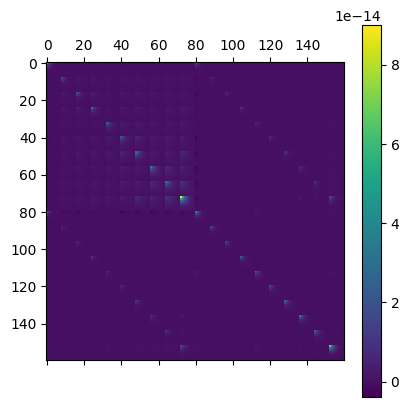

In [14]:
plt.matshow(dv_cov_fid[0:160,0:160])
plt.colorbar()

In [19]:
NOISE_SCALE = 0.01  # Adjust this factor as needed

noise = np.random.multivariate_normal(mean=np.zeros(608), 
                                    cov=NOISE_SCALE * dv_cov_fid, 
                                    size=num_samples)


tmp = dv+noise

### v0 start
dv_aug = tmp
pars_train_aug = pars_train
###v0 end

# # v1 start
# dv_aug = np.vstack((tmp, dv))
# pars_train_aug = np.vstack((pars_train, pars_train))
# # v1 end

In [20]:
num_samples = len(dv_aug)
indices = np.random.permutation(num_samples)
train_size = int(0.9 * num_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_loader_w_aug, val_loader_w_aug, test_loader, zca = prepare_data_for_training(
    train_x=dv_aug[train_indices],
    train_y=pars_train_aug[train_indices],
    val_x=dv_aug[val_indices],
    val_y=pars_train_aug[val_indices],
    test_x=dv_LFI,
    test_y=pars_LFI,
    batch_size=BATCH_SIZE,
    whitening=True
)

# Start Training!

In [19]:
hyperparameter_configs = [
    {
        'test_id': 'data_aug_test_1',
        'hidden_dims': [128, 64, 32, 16, 8],
        'dropout_rate': 0.2
    },
    
]

for config in hyperparameter_configs:
    model = CompressionNN(
        input_dim=train_loader_no_aug.dataset.tensors[0].shape[1],
        output_dim=train_loader_no_aug.dataset.tensors[1].shape[1],
        test_id=config['test_id'],
        hidden_dims=config['hidden_dims'],
        dropout_rate=config['dropout_rate'],
        output_act= torch.nn.Softplus(),
        arch_name = 'ResMLP'
    )
    
    model.zca = zca
    train_losses, val_losses = model.fit(
        train_loader=train_loader_no_aug,
        val_loader=val_loader_no_aug,
        epochs=NUM_EPOCH,
        early_stopping_patience=20,
        loss_fun = torch.nn.L1Loss()
    )

 55%|█████▌    | 166/300 [04:50<04:03,  1.81s/it]

Epoch 166/300:
Training Loss: 0.064413
Validation Loss: 0.060962


 60%|█████▉    | 179/300 [05:16<03:33,  1.77s/it]

Early stopping triggered after 180 epochs
Best validation loss is 0.0592995949474902
Model and preprocessing saved to models/model_data_aug_test_1.pkl


In [21]:
hyperparameter_configs = [
    {
        'test_id': 'data_aug_test_2',
        'hidden_dims': [128, 64, 32, 16, 8],
        'dropout_rate': 0.2
    },
    
]

for config in hyperparameter_configs:
    model = CompressionNN(
        input_dim=train_loader_w_aug.dataset.tensors[0].shape[1],
        output_dim=train_loader_w_aug.dataset.tensors[1].shape[1],
        test_id=config['test_id'],
        hidden_dims=config['hidden_dims'],
        dropout_rate=config['dropout_rate'],
        output_act= torch.nn.Softplus(),
        arch_name = 'ResMLP'
    )
    
    model.zca = zca
    train_losses, val_losses = model.fit(
        train_loader=train_loader_w_aug,
        val_loader=val_loader_w_aug,
        epochs=NUM_EPOCH,
        early_stopping_patience=20,
        loss_fun = torch.nn.L1Loss()
    )

 55%|█████▌    | 166/300 [06:04<05:37,  2.52s/it]

Epoch 166/300:
Training Loss: 0.067212
Validation Loss: 0.068980


 60%|██████    | 181/300 [06:40<04:46,  2.41s/it]

Epoch 181/300:
Training Loss: 0.068033
Validation Loss: 0.061007


 65%|██████▌   | 196/300 [07:18<04:24,  2.54s/it]

Epoch 196/300:
Training Loss: 0.067505
Validation Loss: 0.079550


 70%|███████   | 211/300 [07:47<02:43,  1.83s/it]

Epoch 211/300:
Training Loss: 0.068431
Validation Loss: 0.059707


 75%|███████▌  | 226/300 [08:13<02:07,  1.73s/it]

Epoch 226/300:
Training Loss: 0.068321
Validation Loss: 0.059397


 80%|████████  | 241/300 [08:40<01:43,  1.76s/it]

Epoch 241/300:
Training Loss: 0.067662
Validation Loss: 0.061801


 82%|████████▏ | 245/300 [08:48<01:58,  2.16s/it]

Early stopping triggered after 246 epochs
Best validation loss is 0.05939706061677686
Model and preprocessing saved to models/model_data_aug_test_2.pkl


In [68]:
hyperparameter_configs = [
    {
        'test_id': 'data_aug_test_3',
        'hidden_dims': [128, 64, 32, 16, 8],
        'dropout_rate': 0.2
    },
    
]

for config in hyperparameter_configs:
    model = CompressionNN(
        input_dim=train_loader_w_aug.dataset.tensors[0].shape[1],
        output_dim=train_loader_w_aug.dataset.tensors[1].shape[1],
        test_id=config['test_id'],
        hidden_dims=config['hidden_dims'],
        dropout_rate=config['dropout_rate'],
        output_act= torch.nn.Softplus(),
        arch_name = 'ResMLP'
    )
    
    model.zca = zca
    train_losses, val_losses = model.fit(
        train_loader=train_loader_w_aug,
        val_loader=val_loader_w_aug,
        epochs=NUM_EPOCH,
        early_stopping_patience=20,
        loss_fun = torch.nn.L1Loss()
    )

 55%|█████▌    | 166/300 [10:04<09:31,  4.26s/it]

Epoch 166/300:
Training Loss: 0.061404
Validation Loss: 0.057113


 58%|█████▊    | 174/300 [10:43<07:45,  3.70s/it]

Early stopping triggered after 175 epochs
Best validation loss is 0.056288894751797554
Model and preprocessing saved to models/model_data_aug_test_3.pkl


# plot validations

/global/homes/k/kunhaoz/miniconda3/envs/py39/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))

 RMSE = 0.055
 $R^2$ = 0.940
Error S_8 = 8.613
test 0
test 1
test 2


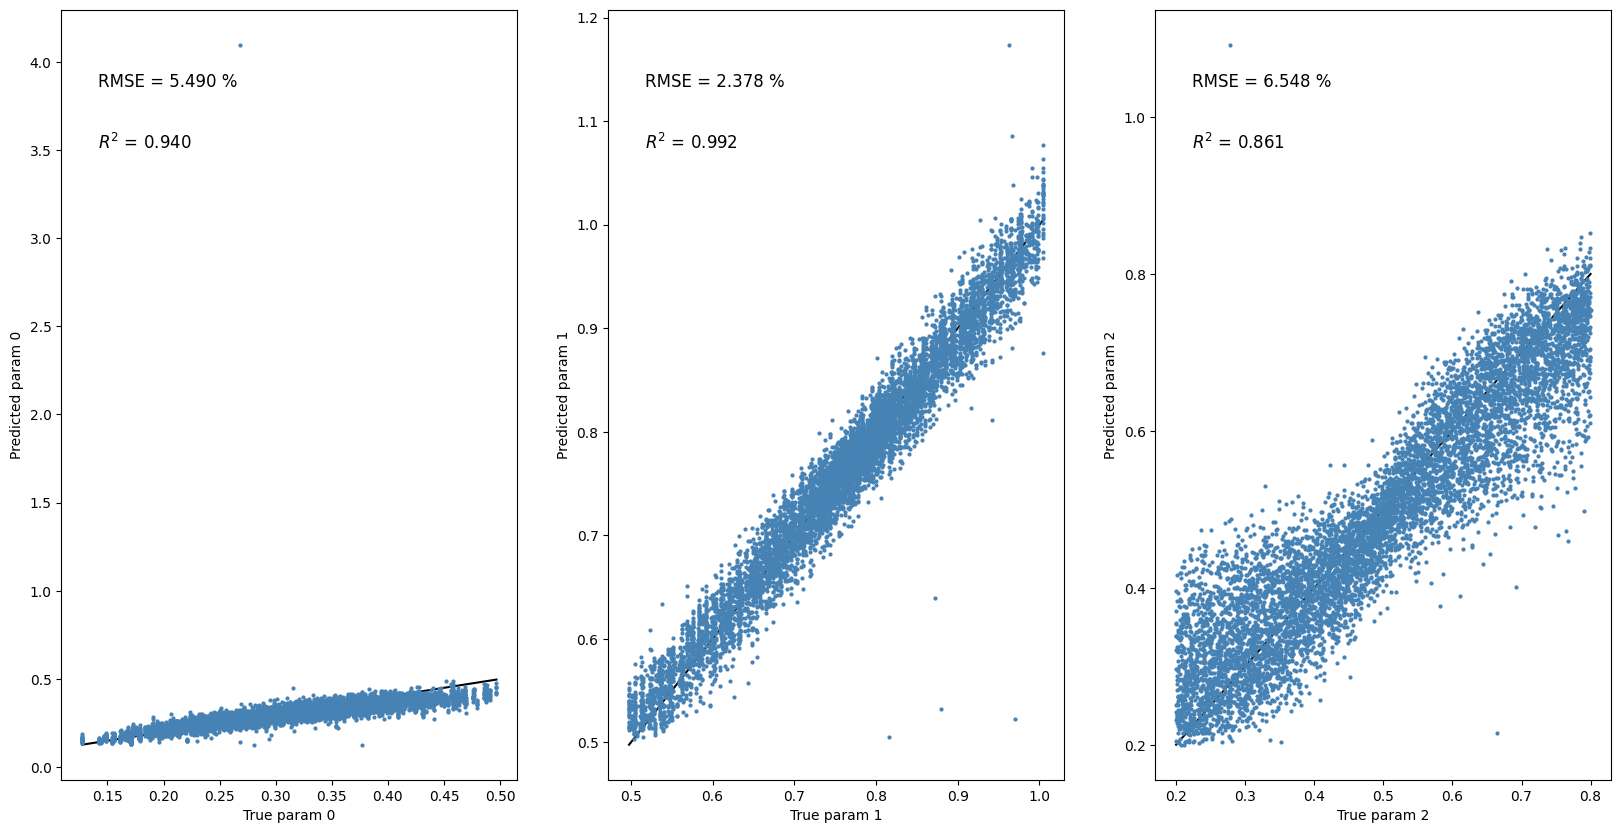

In [20]:
loaded_model = CompressionNN.load('data_aug_test_1')
loaded_model.model.to('cpu')

plot_test_error_all_param_3param(loaded_model, test_loader, n_params=3, label_normalizer=label_normalizer, device='cpu', output=False)


/global/homes/k/kunhaoz/miniconda3/envs/py39/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))

 RMSE = 0.048
 $R^2$ = 0.954
Error S_8 = 8.508
test 0
test 1
test 2


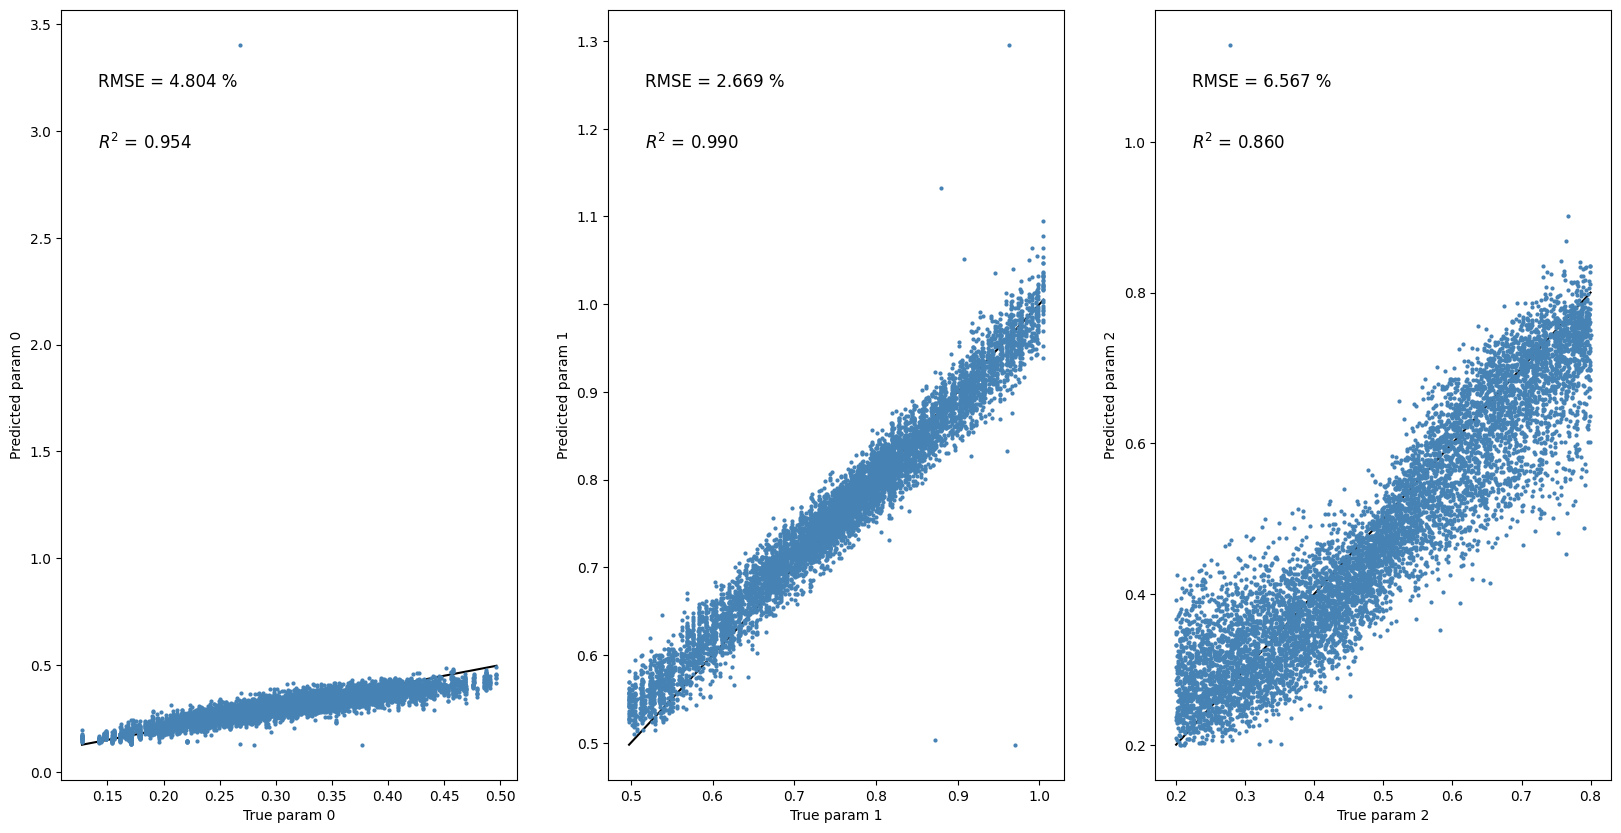

In [22]:
loaded_model = CompressionNN.load('data_aug_test_2')
loaded_model.model.to('cpu')

plot_test_error_all_param_3param(loaded_model, test_loader, n_params=3, label_normalizer=label_normalizer, device='cpu', output=False)


 RMSE = 0.097
 $R^2$ = 0.812
Error S_8 = 8.573
test 0
test 1
test 2


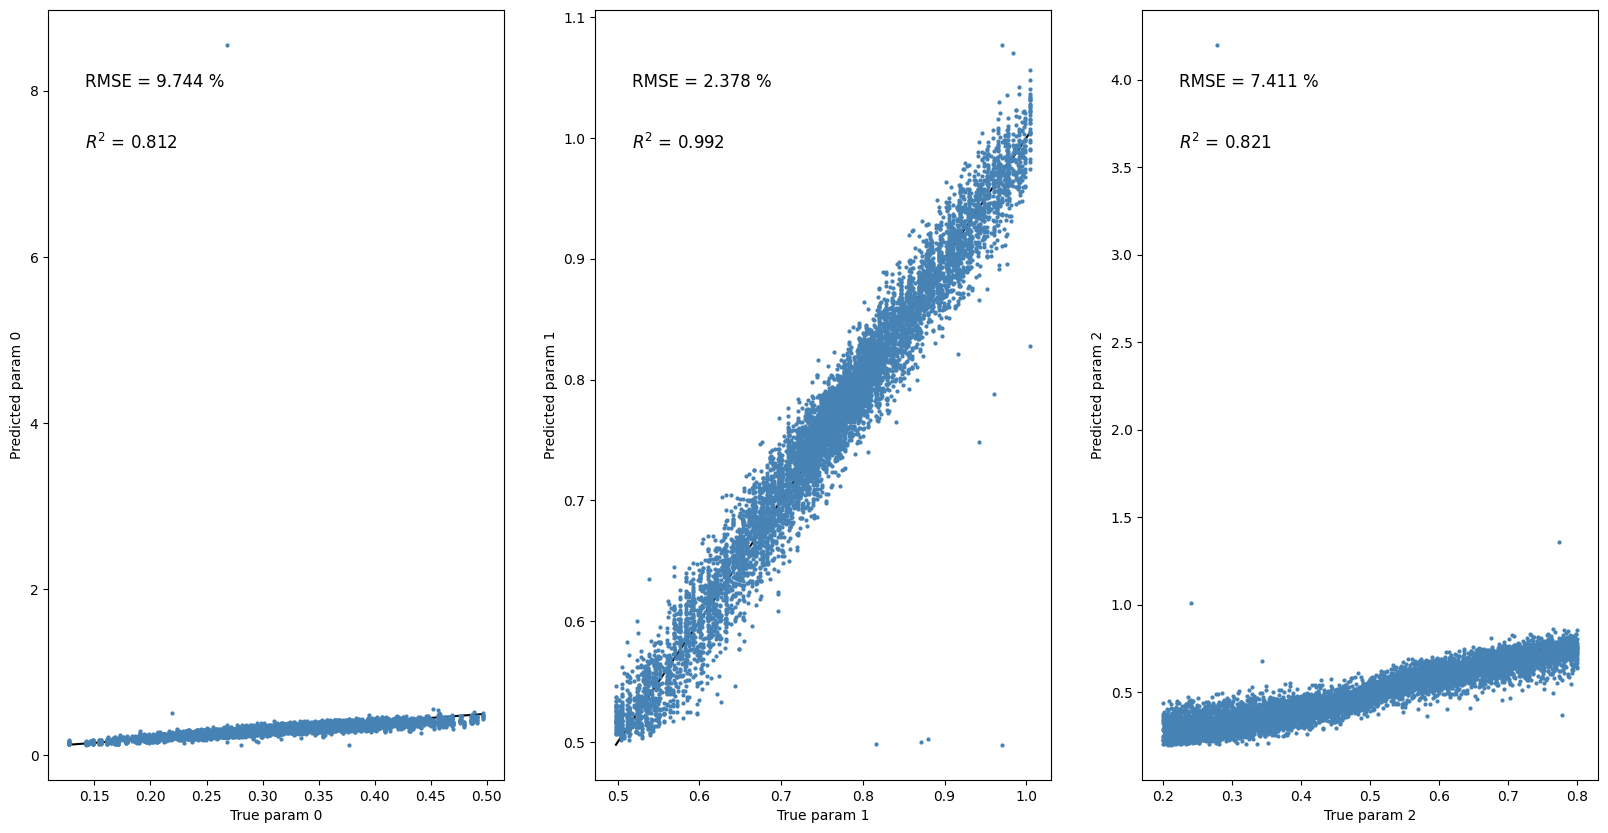

In [69]:
loaded_model = CompressionNN.load('data_aug_test_3')
loaded_model.model.to('cpu')

plot_test_error_all_param_3param(loaded_model, test_loader, n_params=3, label_normalizer=label_normalizer, device='cpu', output=False)
